## 0. Imports Preliminaries

In [1]:
!pip install nltk py-readability-metrics spacy==3.6.1 keras==2.8

In [1]:
#0. Preliminaries
import pandas as pd
import nltk
nltk.download('punkt')
from readability import Readability

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import spacy

In [3]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from transformers import pipeline
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", max_length = 512, truncation = True)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer = tokenizer,
    return_all_scores=True
)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## 1. Load Data

In [5]:
#1. Import Data
df = pd.read_csv("../data/chunked_author_data_UTF8.csv")

In [20]:
df['Author'].value_counts()

Author
Aman Madaan     80
Zhiqing Sun     77
Timo Schick     76
Hugo Touvron    74
GPT-3.5         72
Name: count, dtype: int64

In [21]:
len(df)

379

## 2. Clean Data 

In [7]:
def regex(string: str):
    """
    Function that applies regular expressions to a string based on the specified model.
    :param string: The input string.
    :param model: The model to determine which regular expressions to apply.
    :return: The modified string.
    """
    string = re.sub(r'e\.g\.', 'eg', string)  # replace e.g. with eg
    string = re.sub(r'i\.e\.', 'ie', string)  # replace i.e. with ie
    string = re.sub(r'-', ' ', string)  # replace - with space
    string = re.sub(r'[0-9]', '0', string)  # each digit will be represented as a 0
    string = re.sub(r'\(.*?\)', '', string) # remove parentheses and the text within
    string = re.sub(r'\[.*?\]', '', string) # remove brackets and the text within
    string = re.sub(r"https?:\/\/[a-zA-Z0-9.\/]+", "@", string) # remove links
    string = re.sub('[^A-Za-z0-9\s\.,\?!:;]+', '', string)# Remove special characters, so math formulas simplified.
    string = re.sub(r'\s\s+', ' ', string) # remove if there is more than 1 space, inlcuding new line \n and tab \t
    return string.strip() # Remove extra spaces at the begningining and end.

assert regex("a\t\n b") == "a b"
assert regex("q123") == "q000"
assert regex("a (something something) b (sth th)") == "a b"
assert regex("a [something something] b [sth12 th]") == "a b"
assert regex("2 + 5 % 2") == "0 0 0"
assert regex(",!;:.?") == ",!;:.?"

## 3. Add Features

In [8]:
#Flesch 
def flesch_readability_scale(text):
    try:
        r = Readability(text)
        f = r.flesch()
        score_out = f.score
    #not possible if less than 100 words
    except:
        score_out = np.nan
    return score_out

In [9]:
# Sentiment Analysis (Positive Score)
tokenizer_kwargs = {'truncation':True,'max_length':512}
def sentiment_analysis_score(text):
    results_senti = distilled_student_sentiment_classifier(text, **tokenizer_kwargs)
    positive_score = [x['score'] for x in results_senti[0] if x['label'] == 'positive']
    score_out = positive_score[0] if len(positive_score) == 1 else np.nan
    return score_out                          

In [10]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

assert lexical_diversity('a a b') == 2/3

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize

def avg_word_per_sentence(text):
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(text)])

assert avg_word_per_sentence('I like muffins. Please buy me two of them.') == 5.5

In [12]:
def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

assert avg_word_length('I like giant muffins. Please buy me two of them.') == 3.25

In [13]:
nlp = spacy.load("en_core_web_sm")

In [14]:
#remove proper nouns and POS-tag n grams
def POS_preprocessing(text):
    POS_string = ""
    cleaned_string = ""
    list_sentences = nltk.tokenize.sent_tokenize(text)
    for sentence in list_sentences:
        doc = nlp(sentence)
        for token in doc:
            #first add the text back
            string_out = "Propname" if token.pos_ == "PROPN" else token.text
            sep_out = "" if token.pos_ == "PUNCT" else " "
            cleaned_string = cleaned_string + sep_out + string_out
            #second 
            #POS_out = "" if token.pos_ == "PUNCT" else token.pos_
            POS_string = POS_string + " " + token.pos_
    return pd.Series({
        'cleaned_string': cleaned_string,
        'POS_string': POS_string
    })

In [15]:
def remove_bullet_points(text):
    bulletpoint_delimiters = re.compile(r'(\(i\)|\(ii\)|•)')
    text = re.sub(bulletpoint_delimiters, "", text)
    return text

In [16]:
df['flesch_score'] = df['Chunk'].apply(flesch_readability_scale)

In [17]:
average_score_author = df[['flesch_score', 'Author']].dropna().groupby('Author').mean().reset_index()
average_score_author.columns = ["Author", "mean_flesch"]
df = df.merge(average_score_author, how = "left", on = "Author")
df.loc[df['flesch_score'].isnull(), 'flesch_score'] = df.loc[df['flesch_score'].isnull(), 'mean_flesch']

In [19]:
average_score_author

,Author,mean_flesch
0,Aman Madaan,30.716251
1,GPT-3.5,2.640659
2,Hugo Touvron,30.655460
3,Timo Schick,32.830540
4,Zhiqing Sun,22.733195


In [18]:
df['sent_score'] = df['Chunk'].apply(sentiment_analysis_score)

In [22]:
df['re_text'] = df['Chunk'].apply(regex)
#train has to be run first - a catch statement for that
df['re_text'] = df['re_text'].apply(remove_bullet_points)
#removing double space should be after removing bullet points! leaves a double space sometimes
df[['re_text', 'POS_string']] = df['re_text'].apply(POS_preprocessing)
df['lexical_diversity'] = df['re_text'].apply(lexical_diversity)
df['avg_word_per_sentence'] = df['re_text'].apply(avg_word_per_sentence)
df['avg_word_length'] = df['re_text'].apply(avg_word_length)

In [21]:
df['re_text'][0]

' In the landscape of cloud based Propname Propname Propname, the array of sizes and configurations available presents a challenge in effectively balancing computational cost and performance optimization. This paper introduces Propname, an innovative approach designed to strategically route queries to larger LLMs based on the approximate correctness of outputs from a smaller Propname. At its core, Propname incorporates a few shot self verification mechanism, allowing it to estimate the reliability of its own outputs without the need for additional training. To address the inherent noise in verifications, Propname employs a meta verifier, enhancing the accuracy of these assessments. Experimental results using Propname Propname on five context grounded reasoning datasets illustrate that Propname outperforms established baselines, yielding an up to 00 improvement in the incremental benefit per cost.'

In [23]:
df.to_csv("../data/df_with_features.csv")

In [10]:
#df = pd.read_csv("../data/df_with_features.csv")

In [11]:
#df = df.drop(columns="text")

## Inspect Features

In [25]:
feature_stats = df[['Author', 'flesch_score', 'sent_score', 'lexical_diversity', 'avg_word_per_sentence', 'avg_word_length']].groupby('Author').mean().reset_index()

In [26]:
feature_stats

,Author,flesch_score,sent_score,lexical_diversity,avg_word_per_sentence,avg_word_length
0,Aman Madaan,30.716251,0.473754,0.588613,25.843240,5.100926
1,GPT-3.5,2.640659,0.645164,0.658350,25.618348,5.728765
2,Hugo Touvron,30.655460,0.528844,0.601354,25.186918,5.056994
3,Timo Schick,32.830540,0.453588,0.602921,31.039158,4.997815
4,Zhiqing Sun,22.733195,0.501180,0.575139,27.670971,5.311172


In [ ]:
#export to PowerPoint
#feature_stats.to_clipboard(float_format='%.2f', index=False)

### Compare with GPT-data

In [28]:
GPT_data = pd.read_csv("../data/GPT_data_UTF8_additional_2.csv")

In [30]:
GPT_data = GPT_data.reset_index(drop = True)
df_w_features_GPT = df[df['Author'] == "GPT-3.5"].reset_index(drop = True)
df_w_features_GPT['Author_org'] = ""

for df_row in df_w_features_GPT.index:
   text = df_w_features_GPT.loc[df_row, 'Chunk'][1:500]
   type_text= df_w_features_GPT.loc[df_row, 'Type']
   col_type = "GPT_abstract" if type_text == "abstract_chunked" else ("GPT_introduction" if type_text == "intro_chunked" else "GPT_conclusion")
   for texts in GPT_data.index:
      if text in GPT_data.loc[texts, col_type]:
         df_w_features_GPT.loc[df_row, 'Author_org'] = GPT_data.loc[texts, 'Author']

In [32]:
df_w_features_GPT.loc[df_w_features_GPT['Author_org'] == "", :]

,Unnamed: 0,Author,Pub,Type,Chunk,flesch_score,mean_flesch,sent_score,re_text,POS_string,lexical_diversity,avg_word_per_sentence,avg_word_length,Author_org
34,10,GPT-3.5,"["" The ubiquity of machine learning, particula...",intro_chunked,"The ubiquity of machine learning, particularl...",0.653333,2.640659,0.600239,"The ubiquity of machine learning, particularl...",DET NOUN ADP NOUN NOUN PUNCT ADV ADJ NOUN PUN...,0.588785,23.777778,5.920561,
58,10,GPT-3.5,"[' In the evolving landscape of deep learning,...",conclusion_chunked,"In the evolving landscape of deep learning, t...",3.647313,2.640659,0.731827,"In the evolving landscape of deep learning, t...",ADP DET VERB NOUN ADP ADJ NOUN PUNCT DET NOUN...,0.587983,29.125000,5.759657,
59,11,GPT-3.5,"["" In conclusion, ResMLP presents a compelling...",conclusion_chunked,"In conclusion, ResMLP presents a compelling a...",1.383823,2.640659,0.753702,"In conclusion, Propname presents a compelling...",ADP NOUN PUNCT PROPN VERB DET ADJ NOUN ADP AD...,0.646739,23.000000,5.951087,


In [33]:
#checked manually
df_w_features_GPT.loc[df_w_features_GPT['Author_org'] == "", "Author_org"] = "Hugo Touvron"

In [34]:
stats_GPT_v_authors = df_w_features_GPT[['Author_org', 'flesch_score', 'sent_score', 'lexical_diversity', 'avg_word_per_sentence', 'avg_word_length']].groupby('Author_org').mean().reset_index()

In [35]:
#stats_GPT_v_authors.to_csv("test_gpt.csv", float_format='%.2f', index=False)
stats_GPT_v_authors

,Author_org,flesch_score,sent_score,lexical_diversity,avg_word_per_sentence,avg_word_length
0,Aman Madaan,6.883980,0.687582,0.669898,25.954894,5.555033
1,Hugo Touvron,-0.000706,0.637454,0.655178,24.541821,5.804249
2,Timo Schick,3.868465,0.668909,0.673943,26.067725,5.771274
3,Zhiqing Sun,-0.189104,0.586711,0.634382,25.908951,5.784505


# 3. Split Data

In [36]:
def select_equal_groups(group: pd.core.groupby.generic.DataFrameGroupBy, n: int):

    return group.sample(min(n, len(group)), random_state=42)

share_train = 0.7
share_test = 0.3
samples_train = int(len(df)*(share_train*(1-share_test)))
samples_per_group = int(samples_train/5)

df['ID'] = range(0, len(df))
df_abstract_intro = df[~df['Type'].str.contains("conclusion_chunked")]
df_train= df_abstract_intro.groupby("Author", group_keys=False)\
        .apply(select_equal_groups, samples_per_group)\
        .reset_index(drop=True)

df_test_val = df[~df['ID'].isin(df_train['ID'])]
df_val = df_test_val[~df_test_val['Type'].str.contains("conclusion_chunked")]
df_val, df_test_0  = train_test_split(df_val, train_size = 0.5, stratify = df_val['Author'], random_state = 42)
df_test_1 = df_test_val[df_test_val['Type'].str.contains("conclusion_chunked")]
#df_test, df_val  = train_test_split(df_test_val, train_size = 0.5, stratify = df_test_val['Author'], random_state = 42)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [37]:
df_train['Author'].value_counts()

Author
Aman Madaan     37
GPT-3.5         37
Hugo Touvron    37
Timo Schick     37
Zhiqing Sun     37
Name: count, dtype: int64

In [38]:
df_val['Author'].value_counts()

Author
Aman Madaan     13
Zhiqing Sun     12
Hugo Touvron    11
Timo Schick      9
GPT-3.5          6
Name: count, dtype: int64

In [39]:
df_test_0['Author'].value_counts()

Author
Zhiqing Sun     13
Aman Madaan     13
Hugo Touvron    11
Timo Schick     10
GPT-3.5          5
Name: count, dtype: int64

In [40]:
df_test_1['Author'].value_counts()

Author
GPT-3.5         24
Timo Schick     20
Aman Madaan     17
Hugo Touvron    15
Zhiqing Sun     15
Name: count, dtype: int64

In [43]:
df_test = pd.concat([df_test_0, df_val])
print(df_test['Author'].value_counts())

Author
Aman Madaan     26
Zhiqing Sun     25
Hugo Touvron    22
Timo Schick     19
GPT-3.5         11
Name: count, dtype: int64


In [45]:
len(df_test_1)

91

In [46]:
#punctuation n-grams
punct_vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, use_idf=False, norm='l1', vocabulary=string.punctuation)

In [47]:
pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4))

In [48]:
stopword_vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=nltk.word_tokenize, vocabulary=stopwords.words("english"))

In [49]:
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# 4. Tokenize Datasets

In [50]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def clean_punct(test_str):
    for ele in test_str:
        if ele in punc:
            test_str = test_str.replace(ele, "")
    return test_str

In [51]:
def remove_stopwords(example_text):
    word_tokens = word_tokenize(example_text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stopwords.words("english")]
    return " ".join(filtered_sentence)

In [52]:
def preprocess_data(df, text_col, train = False):
    df = df.reset_index(drop = True)
    #these should be run first before cleaning punctuation and private words and stuff
    #df['flesch_score'] = df[text_col].apply(flesch_readability_scale)
    #commented out for now as takes long to run
    try:
        punct_features = punct_vectorizer.fit_transform(df[text_col]) if train else punct_vectorizer.transform(df[text_col])
        columns = [f'punct_{c}' for c in punct_vectorizer.get_feature_names_out()]
        punct_features_df = pd.DataFrame(punct_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, punct_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Punctuation N-grams: {e}")
    try:
        POS_features = pos_vectorizer.fit_transform(df['POS_string']) if train else pos_vectorizer.transform(df['POS_string'])
        columns = [f'pos_{c}' for c in pos_vectorizer.get_feature_names_out()]
        POS_features_df = pd.DataFrame(POS_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, POS_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating POS N-grams: {e}")

    #lowercase everything
    df[text_col] = df[text_col].apply(str.lower)
    df[text_col] = df[text_col].apply(clean_punct)

    try:
        stopwords_features = stopword_vectorizer.fit_transform(df[text_col]) if train else stopword_vectorizer.transform(df[text_col])
        columns = [f'stop_{c}' for c in stopword_vectorizer.get_feature_names_out()]
        stopwords_features_df = pd.DataFrame(stopwords_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, stopwords_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Stopword N-grams: {e}")

    #remove stopwords here
    df[text_col] = df[text_col].apply(remove_stopwords)
    try:
        words_features = word_vectorizer.fit_transform(df[text_col]) if train else word_vectorizer.transform(df[text_col])
        columns = [f'word_{c}' for c in word_vectorizer.get_feature_names_out()]
        words_features_df = pd.DataFrame(words_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, words_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Word N-grams: {e}")
    return df

In [53]:
df_train_processed = preprocess_data(df_train, 're_text', train = True)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [54]:
df_val_processed = preprocess_data(df_val, 're_text', train = False)

In [55]:
df_test_0_processed = preprocess_data(df_test_0, 're_text', train = False)

In [56]:
df_test_1_processed = preprocess_data(df_test_1, 're_text', train = False)

In [40]:
# df_val_processed.to_pickle("./df_val_processed.pkl")
# df_test_0_processed.to_pickle("./df_test_0_processed.pkl")
# df_test_1_processed.to_pickle("./df_test_1_processed.pkl")

In [57]:
X_train_df = df_train_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
colnames_reg = X_train_df.columns
y_train = df_train_processed['Author']

X_val_df = df_val_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
y_val = df_val_processed['Author']

X_test_0_df = df_test_0_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
y_test_0 = df_test_0_processed['Author']

X_test_1_df = df_test_1_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
y_test_1 = df_test_1_processed['Author']

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprec

In [59]:
X_test_0_scaled = scaler.transform(X_test_0_df)
X_test_1_scaled = scaler.transform(X_test_1_df)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprec

# 5. Exploring the features

## Feature correlation

In [60]:
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as sch

def plot_corr(df, size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    # Compute the correlation matrix for the received dataframe
    # Don't use df.corr() as it is is extremely slow
    corr = np.corrcoef(df.T)
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    ax.set_xticks([0, len(corr)])
    ax.set_yticks([0, len(corr)])
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

plot_corr(X_train_df, size=18)

KeyboardInterrupt: 

### Crafted features

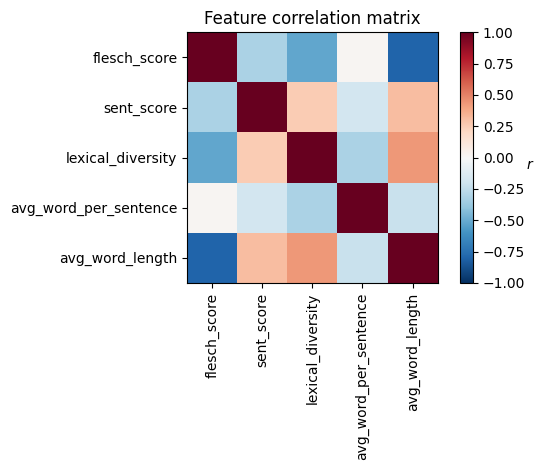

In [61]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
feature_names = colnames_reg.values.tolist()

ax = plt.axes()

target_features = ['flesch_score', 'sent_score', 'lexical_diversity', 'avg_word_per_sentence', 'avg_word_length']
assert [f for f in X_train_df.columns if not f.startswith('punct_') and not f.startswith('word_') and not f.startswith('pos_') and not f.startswith('stop_')] == target_features

im = ax.imshow(np.corrcoef(X_train_df[target_features].T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(list(range(len(target_features))))
ax.set_xticklabels(target_features, rotation=90)
ax.set_yticks(list(range(len(target_features))))
ax.set_yticklabels(list(target_features))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix")
plt.tight_layout()

### Principal Component Analysis

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


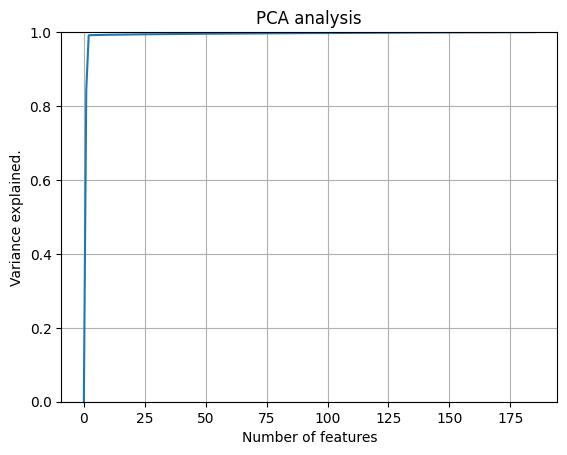

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

feature_names = colnames_reg.values.tolist()

pca = PCA(n_components=min(len(feature_names), len(X_train_df.index)))
pca.fit_transform(X_train_df)
fig, ax = plt.subplots()
ax.set_ylim([0, 1])
var_explained = pca.explained_variance_ratio_.cumsum()
var_explained = np.insert(var_explained, 0, 0)

components = list(range(len(var_explained)))
ax.plot(components, var_explained)
ax.set(xlabel='Number of features', ylabel='Variance explained.',
       title='PCA analysis')
ax.grid()

fig.savefig("pca_analysis.png")
plt.show()

In [63]:
# Keep only the first 25 components.
pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train_df)
X_val_pca = pca.transform(X_val_df)
X_test_0_pca = pca.transform(X_test_0_df)
X_test_1_pca = pca.transform(X_test_1_df)


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprec

# 6. Modelling

In [64]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Grid search

### Logistic regression

In [56]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def grid_search(model, params, X_scaled, X_pca, y, cv=5):
    X_scaled = np.nan_to_num(X_scaled)
    X_pca = np.nan_to_num(X_pca)
    y = np.nan_to_num(y)
    gridSearch_scaled = GridSearchCV(model, params, cv=cv, verbose=1, n_jobs=128)
    gridSearch_scaled.fit(X_scaled, y)
    gridSearch_pca = GridSearchCV(model, params, cv=cv, verbose=1, n_jobs=128)
    gridSearch_pca.fit(X_pca, y)
    return gridSearch_scaled, gridSearch_pca

In [57]:
logi_scaled, logi_pca = grid_search(
    Pipeline([('logi', LogisticRegression())]),
    {'logi__penalty': ['l2', 'l1'],
     'logi__solver': ['saga']},
    X_train_scaled,
    X_train_pca,
    y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linea

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/linea

In [58]:
pd.DataFrame.from_dict(logi_scaled.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logi__penalty,param_logi__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.481267,0.061067,0.048498,0.014959,l2,saga,"{'logi__penalty': 'l2', 'logi__solver': 'saga'}",0.783784,0.783784,0.783784,0.891892,0.783784,0.805405,0.043243,1
1,28.363290,0.040917,0.036995,0.003385,l1,saga,"{'logi__penalty': 'l1', 'logi__solver': 'saga'}",0.729730,0.729730,0.756757,0.891892,0.729730,0.767568,0.063037,2


In [59]:
pd.DataFrame.from_dict(logi_pca.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logi__penalty,param_logi__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014111,0.000091,0.038509,0.011581,l2,saga,"{'logi__penalty': 'l2', 'logi__solver': 'saga'}",0.486486,0.513514,0.594595,0.729730,0.540541,0.572973,0.086148,1
1,0.017569,0.001180,0.045127,0.017680,l1,saga,"{'logi__penalty': 'l1', 'logi__solver': 'saga'}",0.432432,0.432432,0.540541,0.702703,0.540541,0.529730,0.099083,2


### Random forest

In [60]:
rf_scaled, rf_pca = grid_search(
    Pipeline([('rf', RandomForestClassifier())]),
    {'rf__n_estimators': [10, 100, 500, 1000],
     'rf__criterion': ['gini', 'entropy']},
    X_train_scaled,
    X_train_pca,
    y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [61]:
pd.DataFrame.from_dict(rf_scaled.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,2.658738,0.152414,0.036230,0.000494,entropy,500,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.756757,0.837838,0.648649,0.810811,0.702703,0.751351,0.069223,1
2,2.496662,0.086124,0.037942,0.001694,gini,500,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.729730,0.864865,0.675676,0.756757,0.702703,0.745946,0.065314,2
3,4.215937,0.195146,0.067640,0.000759,gini,1000,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.675676,0.810811,0.675676,0.864865,0.702703,0.745946,0.077582,2
7,4.323990,0.151021,0.068842,0.001713,entropy,1000,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.702703,0.810811,0.621622,0.864865,0.729730,0.745946,0.084780,2
1,0.836620,0.087692,0.012054,0.000240,gini,100,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.702703,0.756757,0.594595,0.729730,0.729730,0.702703,0.056692,5
5,0.818736,0.048023,0.012050,0.000458,entropy,100,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.675676,0.756757,0.621622,0.756757,0.648649,0.691892,0.055652,6
0,0.311425,0.089016,0.006910,0.000282,gini,10,"{'rf__criterion': 'gini', 'rf__n_estimators': 10}",0.567568,0.567568,0.459459,0.432432,0.513514,0.508108,0.055125,7
4,0.287954,0.081664,0.007981,0.002718,entropy,10,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.486486,0.621622,0.486486,0.540541,0.351351,0.497297,0.088159,8


In [62]:
pd.DataFrame.from_dict(rf_pca.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.647358,0.026428,0.032608,0.001179,gini,500,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.783784,0.729730,0.729730,0.837838,0.702703,0.756757,0.048347,1
6,0.715284,0.020655,0.032289,0.000932,entropy,500,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.810811,0.756757,0.675676,0.864865,0.648649,0.751351,0.080901,2
7,1.412655,0.073612,0.062311,0.000580,entropy,1000,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.729730,0.756757,0.675676,0.918919,0.594595,0.735135,0.107294,3
3,1.221132,0.048510,0.062855,0.000950,gini,1000,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.756757,0.756757,0.648649,0.837838,0.648649,0.729730,0.072521,4
1,0.159465,0.028594,0.008824,0.001968,gini,100,"{'rf__criterion': 'gini', 'rf__n_estimators': ...",0.837838,0.675676,0.675676,0.783784,0.594595,0.713514,0.086486,5
5,0.179709,0.026583,0.006942,0.000168,entropy,100,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.702703,0.675676,0.621622,0.837838,0.594595,0.686486,0.084780,6
0,0.017775,0.004002,0.001594,0.000345,gini,10,"{'rf__criterion': 'gini', 'rf__n_estimators': 10}",0.540541,0.621622,0.702703,0.675676,0.459459,0.600000,0.089475,7
4,0.024755,0.000462,0.001999,0.000118,entropy,10,"{'rf__criterion': 'entropy', 'rf__n_estimators...",0.567568,0.486486,0.621622,0.540541,0.459459,0.535135,0.057714,8


### Support vector classification

In [63]:
svc_scaled, svc_pca = grid_search(
    Pipeline([('svc', SVC())]),
    {'svc__kernel': ['linear', 'rbf', 'poly'],
     'svc__C': [0.5, 1., 2.]},
    X_train_scaled,
    X_train_pca,
    y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [64]:
pd.DataFrame.from_dict(svc_scaled.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,10.211141,1.079466,0.741298,0.243210,2.0,rbf,"{'svc__C': 2.0, 'svc__kernel': 'rbf'}",0.594595,0.621622,0.594595,0.648649,0.567568,0.605405,0.027562,1
0,9.732349,0.818594,0.618419,0.031042,0.5,linear,"{'svc__C': 0.5, 'svc__kernel': 'linear'}",0.459459,0.459459,0.648649,0.864865,0.513514,0.589189,0.154220,2
3,10.383215,0.644000,0.484324,0.184614,1.0,linear,"{'svc__C': 1.0, 'svc__kernel': 'linear'}",0.459459,0.459459,0.648649,0.864865,0.513514,0.589189,0.154220,2
6,8.754501,1.465571,1.021854,0.466937,2.0,linear,"{'svc__C': 2.0, 'svc__kernel': 'linear'}",0.459459,0.459459,0.648649,0.864865,0.513514,0.589189,0.154220,2
4,10.569560,0.778555,0.593758,0.393747,1.0,rbf,"{'svc__C': 1.0, 'svc__kernel': 'rbf'}",0.378378,0.216216,0.378378,0.486486,0.378378,0.367568,0.086486,5
1,10.753068,0.882379,0.516077,0.260160,0.5,rbf,"{'svc__C': 0.5, 'svc__kernel': 'rbf'}",0.297297,0.189189,0.189189,0.297297,0.324324,0.259459,0.058218,6
2,9.914386,1.552835,0.615192,0.376851,0.5,poly,"{'svc__C': 0.5, 'svc__kernel': 'poly'}",0.189189,0.189189,0.216216,0.216216,0.189189,0.200000,0.013240,7
5,9.423008,1.095688,0.715938,0.213482,1.0,poly,"{'svc__C': 1.0, 'svc__kernel': 'poly'}",0.189189,0.189189,0.216216,0.216216,0.189189,0.200000,0.013240,7
8,9.047900,1.410770,0.919065,0.299847,2.0,poly,"{'svc__C': 2.0, 'svc__kernel': 'poly'}",0.189189,0.189189,0.216216,0.216216,0.189189,0.200000,0.013240,7


In [65]:
pd.DataFrame.from_dict(svc_pca.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.046807,0.009520,0.000661,0.000108,2.0,linear,"{'svc__C': 2.0, 'svc__kernel': 'linear'}",0.756757,0.702703,0.756757,0.864865,0.702703,0.756757,0.059213,1
3,0.027146,0.003856,0.000714,0.000075,1.0,linear,"{'svc__C': 1.0, 'svc__kernel': 'linear'}",0.756757,0.729730,0.729730,0.864865,0.648649,0.745946,0.069644,2
0,0.013025,0.002935,0.000655,0.000030,0.5,linear,"{'svc__C': 0.5, 'svc__kernel': 'linear'}",0.729730,0.648649,0.621622,0.810811,0.648649,0.691892,0.069644,3
4,0.003449,0.000044,0.000935,0.000091,1.0,rbf,"{'svc__C': 1.0, 'svc__kernel': 'rbf'}",0.486486,0.378378,0.432432,0.540541,0.486486,0.464865,0.055125,4
7,0.002508,0.000369,0.000673,0.000079,2.0,rbf,"{'svc__C': 2.0, 'svc__kernel': 'rbf'}",0.486486,0.351351,0.405405,0.540541,0.513514,0.459459,0.070478,5
1,0.003173,0.000282,0.000963,0.000067,0.5,rbf,"{'svc__C': 0.5, 'svc__kernel': 'rbf'}",0.459459,0.405405,0.405405,0.567568,0.432432,0.454054,0.060192,6
8,0.002996,0.000128,0.000646,0.000061,2.0,poly,"{'svc__C': 2.0, 'svc__kernel': 'poly'}",0.324324,0.351351,0.405405,0.432432,0.378378,0.378378,0.038222,7
2,0.002580,0.000180,0.000643,0.000085,0.5,poly,"{'svc__C': 0.5, 'svc__kernel': 'poly'}",0.243243,0.351351,0.432432,0.432432,0.270270,0.345946,0.079074,8
5,0.002717,0.000291,0.000713,0.000097,1.0,poly,"{'svc__C': 1.0, 'svc__kernel': 'poly'}",0.216216,0.351351,0.405405,0.405405,0.297297,0.335135,0.071711,9


## Run the best models from each gridsearch

In [65]:
#merge val and test_0
X_test_scaled = np.concatenate((X_val_scaled, X_test_0_scaled))

In [66]:
print(X_val_scaled.shape)
print(X_test_0_scaled.shape)
print(X_test_scaled.shape)

(51, 44428)
(52, 44428)
(103, 44428)


In [67]:
X_test_pca = np.concatenate((X_val_pca, X_test_0_pca))

In [68]:
y_test = np.concatenate((y_val, y_test_0))

In [69]:
def run_classifier(X_val, X_test, model):
    # Make predictions on the test set
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_1 = model.predict(X_test)
    # Evaluate the accuracy of the model
    return y_pred, y_pred_1

In [70]:
#1. SVC
SVC_model = SVC(kernel = "rbf", C = 2.0)
SVC_model.fit(X_train_scaled, y_train)
predictions_SVC, predictions_SVC_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, SVC_model)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [84]:
predictions_SVC_conclusion

array(['GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'Zhiqing Sun', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'Timo Schick', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'Timo Schick', 'GPT-3.5', 'GPT-3.5', 'Aman Madaan', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'Timo Schick',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'Hugo Touvron',
       'GPT-3.5', 'GPT-3.5', 'Zhiqing Sun', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'Zhiqing Sun', 'GPT-3.5', 'Zhiqing Sun', 'GPT-3.5',
       'Zhiqing Sun', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'Zhiqing Sun', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'Timo Schick',
       'Timo Schick', 'Timo Schick', 'G

In [71]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(SVC_model, X_test_scaled, y_test)
features_array = np.array(colnames_reg)
sorted_idx = perm_importance.importances_mean.argsort()
sorted_idx_10 = sorted_idx[0:10]
plt.barh(features_array[sorted_idx_10], perm_importance.importances_mean[sorted_idx_10])
plt.xlabel("Permutation Importance")

KeyboardInterrupt: 

In [75]:
df_test.loc[14]

Unnamed: 0                                                              14
Author                                                             GPT-3.5
Pub                      [' Supervised Fine-Tuning (SFT) on response de...
Type                                                      abstract_chunked
Chunk                     Supervised Fine-Tuning (SFT) on response demo...
flesch_score                                                      1.302601
mean_flesch                                                       2.640659
sent_score                                                        0.614621
re_text                   Supervised Fine Tuning on response demonstrat...
POS_string                ADJ NOUN NOUN ADP NOUN NOUN VERB ADP PROPN PR...
lexical_diversity                                                  0.57868
avg_word_per_sentence                                            28.142857
avg_word_length                                                   5.664975
ID                       

In [78]:
import eli5

In [82]:
display(eli5.show_prediction(SVC_model, df_test.loc[14]))

In [83]:
#1a. SVC PCA
SVC_model_pca = SVC(kernel = "linear", C = 2.0)
SVC_model_pca.fit(X_train_pca, y_train)
predictions_SVC_pca, predictions_SVC_pca_conclusion = run_classifier(X_test_pca, X_test_1_pca, SVC_model_pca)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [84]:
#2. RF
RF_model = RandomForestClassifier(criterion = "entropy", n_estimators = 500)
RF_model.fit(X_train_scaled, y_train)
predictions_RF, predictions_RF_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, RF_model)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [85]:
#2a. RF PCA
RF_model_pca = RandomForestClassifier(criterion = "gini", n_estimators = 500)
RF_model_pca.fit(X_train_pca, y_train)
predictions_RF_pca, predictions_RF_pca_conclusion = run_classifier(X_test_pca, X_test_1_pca, RF_model_pca)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [86]:
forest_importances = pd.Series(RF_model.feature_importances_, index=colnames_reg)

In [87]:
forest_importances.sort_values(ascending=False).head(50)

flesch_score                0.006887
avg_word_length             0.006043
lexical_diversity           0.004332
pos_space noun              0.004267
pos_noun punct verb         0.004132
stop_the                    0.003697
stop_which                  0.003112
pos_pron aux                0.003071
pos_propn noun              0.002944
pos_noun punct pron         0.002861
pos_punct verb              0.002810
pos_verb pron               0.002756
stop_this                   0.002735
stop_can                    0.002705
pos_noun punct              0.002637
pos_adj noun                0.002539
pos_noun punct pron verb    0.002525
pos_punct det               0.002518
pos_noun noun               0.002494
pos_noun verb               0.002482
pos_noun noun punct verb    0.002456
pos_det propn               0.002451
stop_that                   0.002436
pos_verb adj noun adp       0.002419
pos_space noun punct        0.002419
pos_noun noun punct         0.002396
pos_noun aux                0.002396
s

In [88]:
#3. LR
#same parameters for all data and final 
LR_model = LogisticRegression(penalty = "l2", solver = 'saga')
LR_model.fit(X_train_scaled, y_train)
LR_model_pca = LogisticRegression(penalty = "l2", solver = 'saga')
LR_model_pca.fit(X_train_pca, y_train)
predictions_LR, predictions_LR_conclusion = run_classifier(X_test_scaled, X_test_1_scaled, LR_model)
predictions_LR_pca, predictions_LR_pca_conclusion = run_classifier(X_test_pca, X_test_1_pca, LR_model_pca)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is

In [89]:
df_test_final = pd.concat([df_val, df_test_0])
df_test_final['prediction_SVC'] = predictions_SVC
df_test_final['prediction_SVC_pca'] = predictions_SVC_pca
df_test_final['prediction_RF'] = predictions_RF
df_test_final['prediction_RF_pca'] = predictions_RF_pca
df_test_final['prediction_LR'] = predictions_LR
df_test_final['prediction_LR_pca'] = predictions_LR_pca
df_test_final.to_csv("../data/predictions_test.csv")

In [90]:
df_test_1.loc[:, 'prediction_SVC'] = predictions_SVC_conclusion
df_test_1.loc[:, 'prediction_SVC_pca'] = predictions_SVC_pca_conclusion
df_test_1.loc[:, 'prediction_RF'] = predictions_RF_conclusion
df_test_1.loc[:, 'prediction_RF_pca'] = predictions_RF_pca_conclusion
df_test_1.loc[:, 'prediction_LR'] = predictions_LR_conclusion
df_test_1.loc[:, 'prediction_LR_pca'] = predictions_LR_pca_conclusion
df_test_final.to_csv("../data/predictions_test_conclusion.csv")

C:\Users\maria\AppData\Local\Temp\ipykernel_22572\382943563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_1.loc[:, 'prediction_SVC'] = predictions_SVC_conclusion
C:\Users\maria\AppData\Local\Temp\ipykernel_22572\382943563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_1.loc[:, 'prediction_SVC_pca'] = predictions_SVC_pca_conclusion
C:\Users\maria\AppData\Local\Temp\ipykernel_22572\382943563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score, precision_score

default_metrics = {
    'accuracy': accuracy_score,
    'recall': lambda y_t, y_p: recall_score(y_t, y_p, zero_division="warn", average='micro'),
    'precision': lambda y_t, y_p: precision_score(y_t, y_p, zero_division="warn", average='micro'),
    'f1': lambda y_t, y_p: f1_score(y_t, y_p, zero_division= "warn", average ='macro')
}

mapping_authors = {'Aman Madaan': 1, 'Hugo Touvron': 2, 'Zhiqing Sun': 3, 'Timo Schick': 4, 'GPT-3.5': 5}
def plot_accuracy(df, column, metrics):
    y_true = df['Author'].map(mapping_authors)
    y_pred = df[column].map(mapping_authors)

    # Remove labels and display_labels not present in y_true
    labels = [1, 2, 3, 4, 5]
    display_labels = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5']

    # Plot count confusion matrix
    cm_disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=labels, display_labels=display_labels)

    # Show plot
    plt.show()

    # Calculate metrics
    metrics = {metric_name: metric_func(y_true, y_pred) for metric_name, metric_func in metrics.items()}
    print(metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

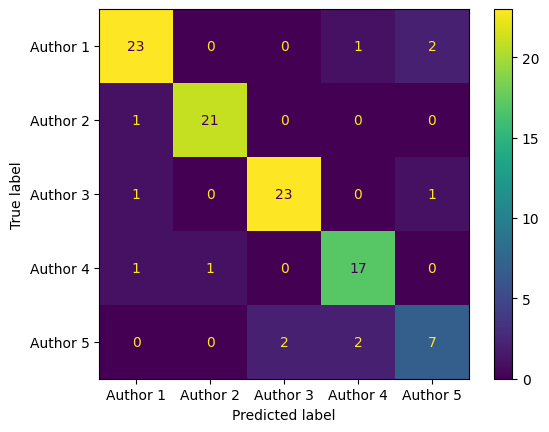

{'accuracy': 0.883495145631068, 'recall': 0.883495145631068, 'precision': 0.883495145631068, 'f1': 0.8595244755244755}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [92]:
plot_accuracy(df_test_final, 'prediction_LR', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

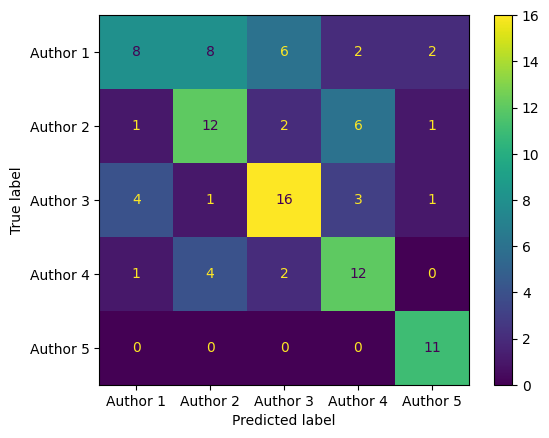

{'accuracy': 0.5728155339805825, 'recall': 0.5728155339805825, 'precision': 0.5728155339805825, 'f1': 0.591134339169383}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [93]:
plot_accuracy(df_test_final, 'prediction_LR_pca', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

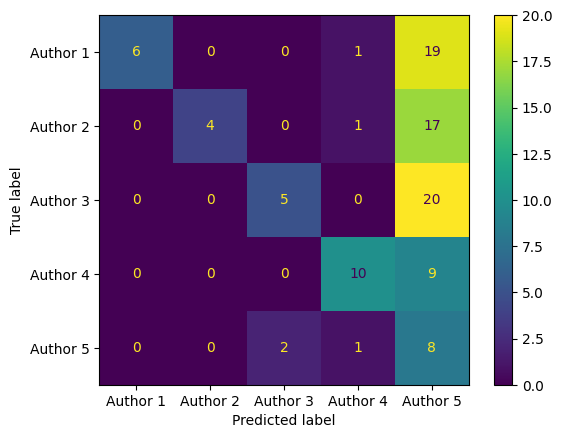

{'accuracy': 0.32038834951456313, 'recall': 0.32038834951456313, 'precision': 0.32038834951456313, 'f1': 0.3621336996336996}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [94]:
plot_accuracy(df_test_final, 'prediction_SVC', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

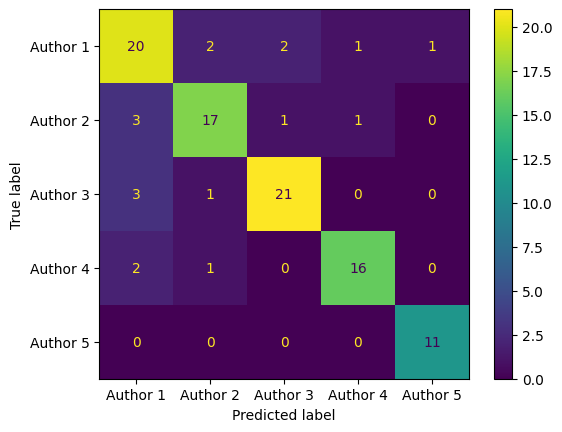

{'accuracy': 0.8252427184466019, 'recall': 0.8252427184466019, 'precision': 0.8252427184466019, 'f1': 0.8419935752595004}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [95]:
plot_accuracy(df_test_final, 'prediction_SVC_pca', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

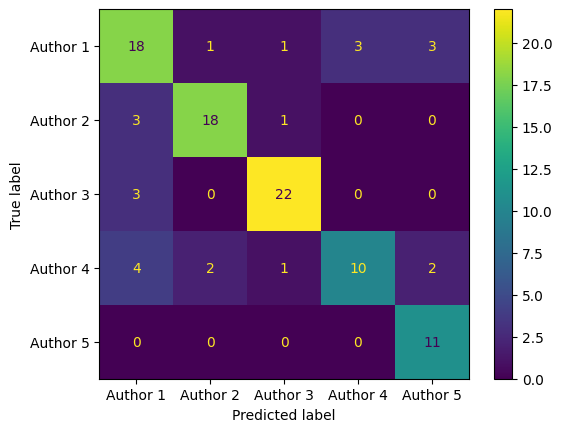

{'accuracy': 0.7669902912621359, 'recall': 0.7669902912621359, 'precision': 0.7669902912621359, 'f1': 0.7647381567614125}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [96]:
plot_accuracy(df_test_final, 'prediction_RF', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

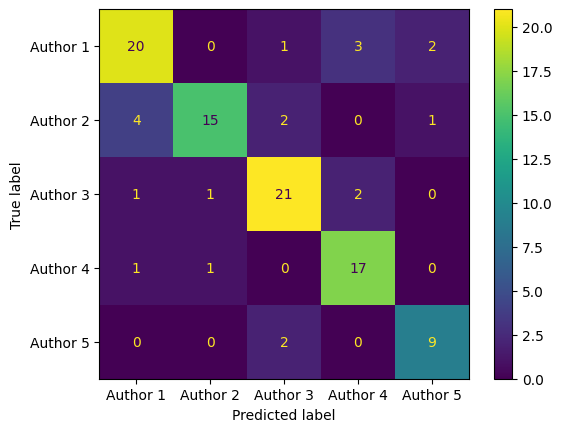

{'accuracy': 0.7961165048543689, 'recall': 0.7961165048543689, 'precision': 0.7961165048543689, 'f1': 0.794773587712269}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [97]:
plot_accuracy(df_test_final, 'prediction_RF_pca', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

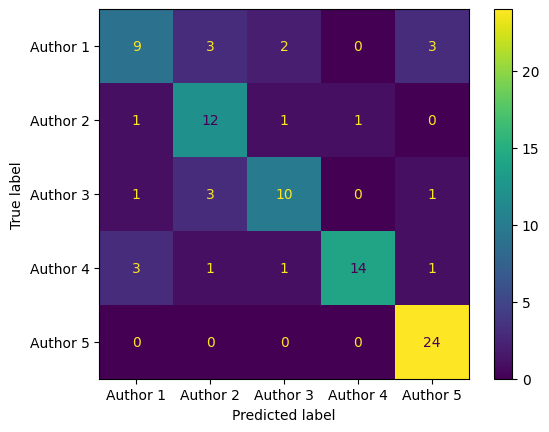

{'accuracy': 0.7582417582417582, 'recall': 0.7582417582417582, 'precision': 0.7582417582417582, 'f1': 0.7363686128007565}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [98]:
plot_accuracy(df_test_1, 'prediction_SVC_pca', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

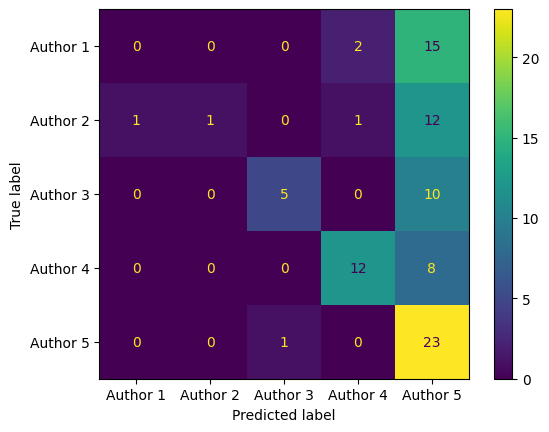

{'accuracy': 0.45054945054945056, 'recall': 0.45054945054945056, 'precision': 0.45054945054945056, 'f1': 0.35738095238095235}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [99]:
plot_accuracy(df_test_1, 'prediction_SVC', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

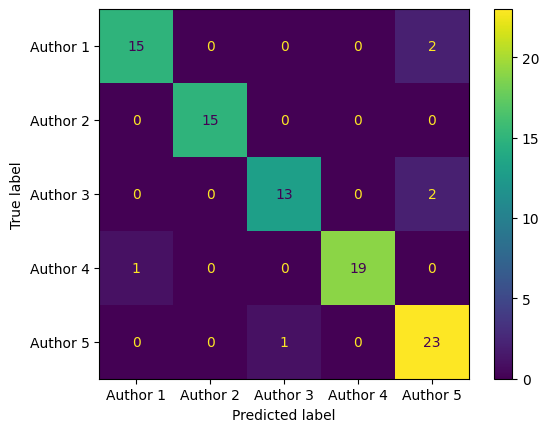

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

{'accuracy': 0.9340659340659341, 'recall': 0.9340659340659341, 'precision': 0.9340659340659341, 'f1': 0.936392478380308}


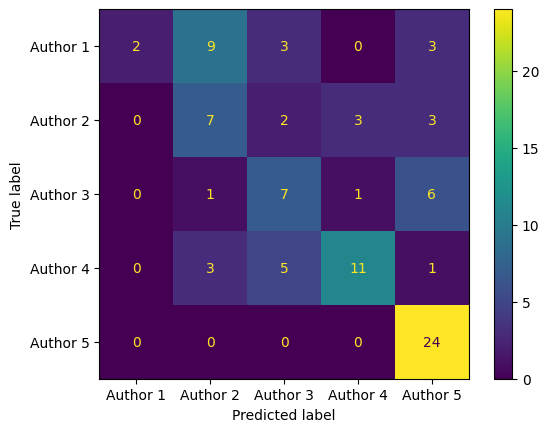

{'accuracy': 0.5604395604395604, 'recall': 0.5604395604395604, 'precision': 0.5604395604395604, 'f1': 0.49269659805250826}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [100]:
plot_accuracy(df_test_1, 'prediction_LR', default_metrics)
plot_accuracy(df_test_1, 'prediction_LR_pca', default_metrics)

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

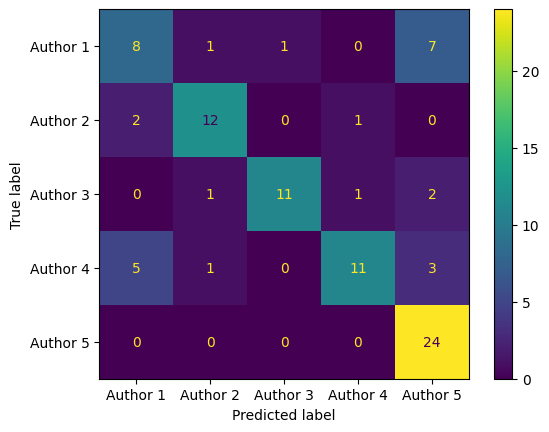

c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

{'accuracy': 0.7252747252747253, 'recall': 0.7252747252747253, 'precision': 0.7252747252747253, 'f1': 0.7162962962962963}


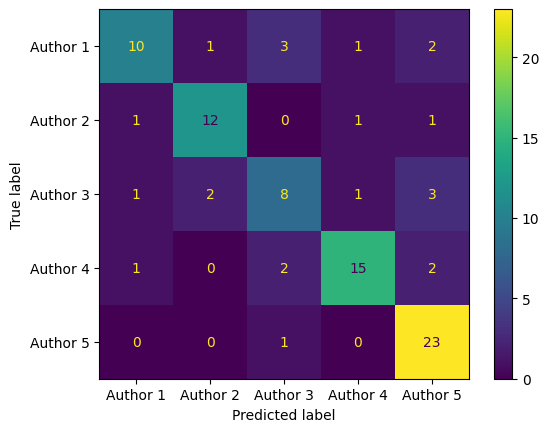

{'accuracy': 0.7472527472527473, 'recall': 0.7472527472527473, 'precision': 0.7472527472527473, 'f1': 0.7288456250343727}


c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\maria\anaconda3\envs\fl_project_analysis\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Che

In [61]:
plot_accuracy(df_test_1, 'prediction_RF', default_metrics)
plot_accuracy(df_test_1, 'prediction_RF_pca', default_metrics)

In [62]:
import eli5

In [68]:
colnames_reg_list = colnames_reg.tolist()

In [123]:
eli5.show_weights(LR_model, feature_names = colnames_reg_list)

In [82]:
predictions_LR_conclusion

array(['GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'Zhiqing Sun', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5', 'GPT-3.5',
       'GPT-3.5', 'Aman Madaan', 'GPT-3.5', 'Aman Madaan', 'Aman Madaan',
       'Aman Madaan', 'GPT-3.5', 'Aman Madaan', 'Aman Madaan',
       'Aman Madaan', 'Aman Madaan', 'Aman Madaan', 'Aman Madaan',
       'Aman Madaan', 'Aman Madaan', 'Aman Madaan', 'Aman Madaan',
       'Aman Madaan', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron', 'Hugo Touvron',
       'Zhiqing Sun', 'GPT-3.5', 'Zhiqing Sun', 'Zhiqing Sun',
       'Zhiqing Sun', 'GPT-3.5', 'Zhiqing Sun', 'Zhiqing Sun',
       'Zhiqing Sun', 'Zhiqing Sun'

In [119]:
df_test_final = df_test_final.reset_index(drop = True)

In [120]:
df_test_final[df_test_final['Author'] == "GPT-3.5"]

,Unnamed: 0,Author,Pub,Type,Chunk,flesch_score,mean_flesch,sent_score,re_text,POS_string,lexical_diversity,avg_word_per_sentence,avg_word_length,ID,prediction_SVC,prediction_SVC_pca,prediction_RF,prediction_RF_pca,prediction_LR,prediction_LR_pca
11,10,GPT-3.5,"[' In the contemporary landscape, the influenc...",abstract_chunked,"In the contemporary landscape, the influence ...",-7.259345,2.640659,0.530393,"In the contemporary landscape, the influence ...",ADP DET ADJ NOUN PUNCT DET NOUN ADP NOUN NOUN...,0.565371,23.583333,5.992933,10,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
13,14,GPT-3.5,[' Supervised Fine-Tuning (SFT) in conjunction...,intro_chunked,Supervised Fine-Tuning (SFT) in conjunction w...,2.681263,2.640659,0.536131,Supervised Fine Tuning in conjunction with Pr...,ADJ ADJ NOUN ADP NOUN ADP PROPN PROPN ADP PRO...,0.597701,29.000000,5.528736,100,Zhiqing Sun,GPT-3.5,GPT-3.5,Zhiqing Sun,Zhiqing Sun,GPT-3.5
16,4,GPT-3.5,[' In the realm of natural language processing...,intro_chunked,"In the realm of natural language processing, ...",-4.235455,2.640659,0.730229,"In the realm of natural language processing, ...",ADP DET NOUN ADP ADJ NOUN NOUN PUNCT DET NOUN...,0.670213,26.857143,5.765957,90,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
25,23,GPT-3.5,[' The fusion of pretrained language models wi...,intro_chunked,The fusion of pretrained language models with...,-6.146529,2.640659,0.778760,The fusion of pretrained language models with...,DET NOUN ADP VERB NOUN NOUN ADP ADJ NOUN NOUN...,0.647059,30.600000,5.823529,109,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
38,18,GPT-3.5,"["" Collaborative writing involves a dynamic pr...",abstract_chunked,Collaborative writing involves a dynamic proc...,11.989098,2.640659,0.652487,Collaborative writing involves a dynamic proc...,ADJ NOUN VERB DET ADJ NOUN ADP NOUN PUNCT VER...,0.610063,22.714286,5.484277,18,Timo Schick,GPT-3.5,GPT-3.5,GPT-3.5,Timo Schick,GPT-3.5
49,20,GPT-3.5,[' While some natural language processing (NLP...,abstract_chunked,While some natural language processing (NLP) ...,11.447874,2.640659,0.572715,While some natural language processing tasks ...,SCONJ DET ADJ NOUN NOUN NOUN AUX AUX VERB ADP...,0.648855,21.833333,5.717557,20,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
55,14,GPT-3.5,[' Supervised Fine-Tuning (SFT) on response de...,abstract_chunked,Supervised Fine-Tuning (SFT) on response demo...,1.302601,2.640659,0.614621,Supervised Fine Tuning on response demonstrat...,ADJ NOUN NOUN ADP NOUN NOUN VERB ADP PROPN PR...,0.578680,28.142857,5.664975,14,Zhiqing Sun,GPT-3.5,GPT-3.5,Zhiqing Sun,Zhiqing Sun,GPT-3.5
56,17,GPT-3.5,[' Natural Language Processing (NLP) has made ...,intro_chunked,Natural Language Processing (NLP) has made re...,4.357586,2.640659,0.636048,Propname Propname Propname has made remarkabl...,PROPN PROPN PROPN AUX VERB ADJ NOUN PUNCT VER...,0.664634,23.428571,5.762195,103,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
58,22,GPT-3.5,[' This paper introduces an innovative approac...,abstract_chunked,This paper introduces an innovative approach ...,-1.567229,2.640659,0.541911,This paper introduces an innovative approach ...,DET NOUN VERB DET ADJ NOUN ADP VERB ADJ NOUN ...,0.697479,23.800000,6.050420,22,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
60,18,GPT-3.5,"["" Despite the collaborative nature of writing...",intro_chunked,Despite the collaborative nature of writing p...,9.701935,2.640659,0.649570,Despite the collaborative nature of writing p...,SCONJ DET ADJ NOUN ADP NOUN NOUN VERB NOUN PU...,0.631285,25.571429,5.553073,104,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,Timo Schick,GPT-3.5


In [122]:
eli5.show_weights(RF_model, feature_names = colnames_reg_list, top = 20)

Weight,Feature
0.0069 ± 0.0519,flesch_score
0.0060 ± 0.0467,avg_word_length
0.0043 ± 0.0352,lexical_diversity
0.0043 ± 0.0377,pos_space noun
0.0041 ± 0.0330,pos_noun punct verb
0.0037 ± 0.0285,stop_the
0.0031 ± 0.0243,stop_which
0.0031 ± 0.0283,pos_pron aux
0.0029 ± 0.0244,pos_propn noun
0.0029 ± 0.0218,pos_noun punct pron


In [121]:
colnames_reg_list = colnames_reg.to_list()
eli5.show_prediction(RF_model, X_test_scaled[11], top =20, feature_names = colnames_reg_list)

In [78]:
df_test_1

,Unnamed: 0.1,Unnamed: 0,Author,Pub,Type,Chunk,flesch_score,mean_flesch,ID,sent_score,...,POS_string,lexical_diversity,avg_word_per_sentence,avg_word_length,prediction_SVC,prediction_SVC_pca,prediction_RF,prediction_RF_pca,prediction_LR,prediction_LR_pca
288,288,0,GPT-3.5,[' AutoMix emerges as a promising solution in ...,conclusion_chunked,AutoMix emerges as a promising solution in th...,4.826424,2.640659,288,0.805644,...,PROPN VERB ADP DET ADJ NOUN ADP DET NOUN ADP ...,0.614865,24.666667,5.513514,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
289,289,1,GPT-3.5,"[' In this study, we introduced SELF-REFINE, a...",conclusion_chunked,"In this study, we introduced SELF-REFINE, a n...",4.699310,2.640659,289,0.800223,...,ADP DET NOUN PUNCT PRON VERB PROPN PROPN PUNC...,0.613095,33.600000,5.529762,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
290,290,2,GPT-3.5,"[' In this work, we introduced FLOWGEN, a grap...",conclusion_chunked,"In this work, we introduced FLOWGEN, a graph ...",17.461421,2.640659,290,0.702326,...,ADP DET NOUN PUNCT PRON VERB PROPN PUNCT DET ...,0.722222,25.200000,5.317460,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
291,291,3,GPT-3.5,"[' In this work, we introduced a method for cu...",conclusion_chunked,"In this work, we introduced a method for cura...",-10.699901,2.640659,291,0.765929,...,ADP DET NOUN PUNCT PRON VERB DET NOUN ADP VER...,0.691729,26.600000,5.909774,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
292,292,4,GPT-3.5,"[' In conclusion, this paper introduces and ad...",conclusion_chunked,"In conclusion, this paper introduces and addr...",-6.644543,2.640659,292,0.850744,...,ADP NOUN PUNCT DET NOUN NOUN CCONJ VERB DET A...,0.692857,35.000000,5.628571,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5,GPT-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,374,86,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,We have devised a novel approach for the chal...,36.064326,32.830540,374,0.628488,...,PRON AUX VERB DET ADJ NOUN ADP DET ADJ NOUN A...,0.541237,32.333333,5.015464,Timo Schick,Aman Madaan,Aman Madaan,Aman Madaan,Timo Schick,Timo Schick
375,375,87,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,As an exhaustive search for the highest-scorin...,34.921247,32.830540,375,0.494213,...,ADP DET ADJ NOUN ADP DET ADJ NOUN NOUN SPACE ...,0.619469,45.200000,4.960177,GPT-3.5,Timo Schick,Hugo Touvron,Zhiqing Sun,Timo Schick,Timo Schick
376,376,88,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,This result strongly suggests that our transit...,36.884301,32.830540,376,0.469552,...,DET NOUN ADV VERB SCONJ PRON NOUN VERB NOUN A...,0.561086,27.625000,4.764706,Timo Schick,Timo Schick,Timo Schick,Timo Schick,Timo Schick,Timo Schick
377,377,89,Timo Schick,[' We have devised a novel approach for the ch...,conclusion_chunked,"Of course, such a revision does not\nhave to b...",23.600754,32.830540,377,0.464467,...,ADV ADV PUNCT DET DET NOUN AUX PART SPACE VER...,0.632768,35.400000,4.943503,Timo Schick,Aman Madaan,Aman Madaan,Timo Schick,Timo Schick,Timo Schick


# Agglomerative clustering

/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/lluneta/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


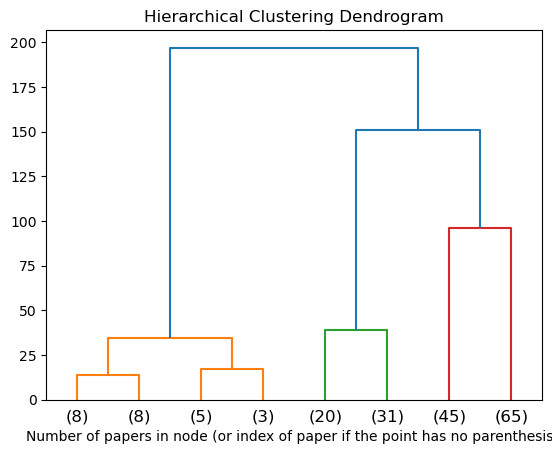

In [67]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold = 0, n_clusters=None)

model = model.fit(X_train_df)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of papers in node (or index of paper if the point has no parenthesis).")
plt.show()